# Import modules

In [67]:
# Code by: O, Wani, 2021

import numpy as np                      # for scientific computing and array analysis
import pandas as pd                     # for working with data strcutures
from scipy.integrate import odeint      # for working with ordinary differential equations
import scipy.stats as stats
import scipy.signal as sg

# displaying plots inline 
%matplotlib inline                      

import matplotlib.pyplot as plt         # for 2D plotting

import math                             # for mathematical functions defined by the C standard
import statsmodels.api as sm            # for autocorrelation function
import os                               # for interacting with the operating system
import seaborn as sns                   # for 3D plotting
import astroabc                         # for inference of SDE parameters
import ipynb                            # for importing ipynb files as modules
import random                           # for pseudo-random number generators
import timeit

os.chdir('/home/owani/Office/Berkeley/Scripts/sde') # set working directory


In [68]:
from ipynb.fs.full.import_data import get_data, get_station_name 
# Import data

# import helper functions
from CatchmentBasics import *
from Data_analysis_helper import *

# Load data


In [69]:
# Define variables that contain the data of all catchments
discharge_obs= np.zeros([5,3000])
discharge_real= np.zeros([5,3000])
rain_obs = np.zeros([5,3000])
Temp_obs = np.zeros([5,3000])

In [70]:
%%capture

#  PlumIsland     - 18
# load time series of rainfall, discharge, temperature 

Temp =  np.array(get_data(18,['AirTemperature']).loc['2005-1-1':'2015-1-1'].mean(axis=1))[0:3000]
rain =  np.asarray(get_data(18,['Precipitation']).loc['2005-1-1':'2015-1-1'][0:3000]['PIE_Precipitation'])
A_discharge = np.asarray(get_data(18,['Discharge']).loc['2005-1-1':'2015-1-1'][0:3000]['Middleton_Discharge'])
discharge_real[0,:] = A_discharge
discharge = A_discharge/np.mean(A_discharge)
discharge_obs[0,:] = discharge
rain_obs[0,:] = rain
Temp_obs[0,:] = Temp

# A = 3

# Kellog 15
# load time series of rainfall, discharge, temperature 

Temp =  np.array(get_data(15,['AirTemperature']).loc['2005-1-1':'2015-1-1'].mean(axis=1))[0:3000]
rain =  np.asarray(get_data(15,['Precipitation']).loc['2005-1-1':'2015-1-1'][0:3000]['KBS002_Precipitation'])
A_discharge = np.asarray(get_data(15,['Discharge']).loc['2005-1-1':'2015-1-1'][0:3000]['KBS096_Discharge'])
discharge_real[1,:] = A_discharge
discharge =A_discharge/np.mean(A_discharge)
discharge_obs[1,:] = discharge
rain_obs[1,:] = rain
Temp_obs[1,:] = Temp

#  Harvard       - 12
# load time series of rainfall, discharge, temperature 

Temp =  np.array(get_data(12,['AirTemperature']).loc['2008-1-1':'2018-1-1'].mean(axis=1))[0:3000]
rain =  np.asarray(get_data(12,['Precipitation']).loc['2008-1-1':'2018-1-1'][0:3000]['HF001_Precipitation'])
A_discharge = np.asarray(get_data(12,['Discharge']).loc['2008-1-1':'2018-1-1'][0:3000]['NelsonWeir_Discharge'])
discharge_real[2,:] = A_discharge
discharge =A_discharge/np.mean(A_discharge)
discharge_obs[2,:] = discharge
rain_obs[2,:] = rain
Temp_obs[2,:] = Temp



#HJ Andrews
# load time series of rainfall, discharge, temperature 

Temp = np.array(get_data(4,['AirTemperature']).loc['2005-1-1':'2015-1-1'].mean(axis=1))[0:3000]
rain = np.array(get_data(4,['Precipitation']).loc['2005-1-1':'2015-1-1'].mean(axis=1))[0:3000]
A_discharge = np.asarray(get_data(4,['Discharge']).loc['2005-1-1':'2015-1-1'][0:3000]['GSLOOK_Discharge'])
discharge_real[3,:] = A_discharge
discharge =A_discharge/np.mean(A_discharge)
discharge_obs[3,:] = discharge
rain_obs[3,:] = rain
Temp_obs[3,:] = Temp
#temp = get_data(4,['AirTemperature']).loc['2005-1-1':'2015-1-1'][0:3000]['VANMET_AirTemperature_50cm']
#temp[temp<0]=0
#swe = get_data(4,['SWE']).loc['2005-1-1':'2015-1-1'][0:3000]['VANMET_SWE']
#sweb = swe/np.amax(swe)


# Hubbard 13
# load time series of rainfall, discharge, temperature 

Temp =  np.array(get_data(13,['AirTemperature']).loc['2005-1-1':'2015-1-1'].mean(axis=1))[0:3000]
rain =  np.asarray(get_data(13,['Precipitation']).loc['2005-1-1':'2015-1-1'][0:3000]['WS7_Precipitation'])
A_discharge = np.asarray(get_data(13,['Discharge']).loc['2005-1-1':'2015-1-1'][0:3000]['WS7_Discharge'])
discharge_real[4,:] = A_discharge
discharge = A_discharge/np.mean(A_discharge)
discharge_obs[4,:] = discharge
rain_obs[4,:] = rain
Temp_obs[4,:] = Temp

# Define SDE

The rainfall runoff model can be described as a stochastic differential equation:


$d\mathcal{S}_t= [\mathcal{R}_t+\mathcal{M}_t-\mathcal{E}_t-\mathcal{Q}_t]\cdot dt+g(\mathcal{S}_t,\mathcal{R}_t)\cdot dW_t$ 

We see that: $ d\mathcal{Q}/d\mathcal{S} = \frac{(d\mathcal{Q}/dt)}{(d\mathcal{S}/dt)}$

Such that:
$ d\mathcal{Q}/d\mathcal{S} = \frac{(d\mathcal{Q}/dt)}{\mathcal{R}_t-\mathcal{Q}_t-\mathcal{M}_t-\mathcal{E}_t}$

We know that the recession equation for catchments, according to Brutsaert and Nieber [1977], is:
$-d\mathcal{Q}/dt = a\mathcal{Q}^b$

Assuming: $\mathcal{Q} \gg \mathcal{R}, \mathcal{M}, \mathcal{E} \\$
$ d\mathcal{Q}/d\mathcal{S} = \frac{(d\mathcal{Q}/dt)}{-\mathcal{Q}}$;
$ d\mathcal{Q}/d\mathcal{S} = a\mathcal{Q}^{b-1}$

Integrating both sides

$\int d\mathcal{S} = \int \frac{1}{a}\mathcal{Q}^{1-b}d\mathcal{Q}\\ $
$\mathcal{Q}=f(\mathcal{S})=\mathcal{Q_{ref}}(\mathcal{S}-\mathcal{S_o})^{1/(2-b)}/k$

Now let us define our modules for snowmelt and evapotranspiration 
(assuming they will have model deficits, which will be taken into account by the stochasticity in the SDE)

$\mathcal{M} = \texttt{ddf}\cdot (T-T_1)\\$
$\mathcal{E} =  E_{max}\cdot \frac{(T-T_{min})}{(T_{max}-T_{min})} + E_{min}\cdot \frac{(T_{max}-T)}{(T_{max}-T_{min})}$

The final effective discharge will be equal to 
$\mathcal{Q_{eff}}=A\cdot \mathcal{Q}$

The subprocesses we have: $\mathcal{S},\mathcal{R},\mathcal{M},\mathcal{E}$

The parameters we have: $A,b,k,\mathcal{S_o},\mathcal{Q_{ref}},\texttt{ddf},E_{max},E_{min}$

In [128]:
# Plots with uncertainty intervals

def sde(par, rain, Temp, runs, dt =1 , T = 3000):
    
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    x = np.zeros([n,runs])
    Qeff = np.ones([n,runs])
    A=par[0]; b=par[1]; k=par[2]; Qref=par[3]; ddf=par[4]; 
    Emax=par[5]; Emin=par[6];bf = par[7]; es=par[8] 
    
    E = Emax*(Temp-Temp.min())/(Temp.max()-Temp.min()) + Emin*(Temp.max()-Temp)/(Temp.max()-Temp.min())
    M = ddf*np.maximum(Temp,0)
    
    for j in range(runs):
        for i in range(n - 1):
            x[i + 1,j] =max(0,(bf + x[i,j] + (rain[i]-E[i]+M[i]-Qref*((x[i,j])/k)**(1/(2-b)))*dt + (es*x[i,j])*np.random.normal(0,np.sqrt(dt),1)))

        if np.isnan(np.sum(A*(Qref*((x[0:n,j])/k)**(1/(2-b)))))==False:
                try:
                    Qeff[:,j] = (A*(Qref*((x[0:n,j])/k)**(1/(2-b))))        
                except:
                    Qeff[:,j] = np.full(n,np.inf)
                 
        else: 
            Qeff[:,j] = np.full(n,np.inf)
    
    return Qeff 

In [72]:
# Define parameters
par0 = {'A':0.3,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.15}  
par1 = {'A':.2,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':1.,'es':0.15}  
par2 = {'A':0.3,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.2,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.1}  
par3 = {'A':0.15,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.2}  
par4 = {'A':1.0,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':-1.,'es':1.2}  
# as a dictionary

par = np.empty((5,9))


for i in range(5):
    par[i,:] = np.array(list(eval('{}{}'.format('par', i)).values())) # as an np.array

# Optimize

In [8]:
from scipy.optimize import minimize

In [9]:
# Define parameters
par0 = {'A':0.3,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.15}  
par1 = {'A':.2,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':1.,'es':0.15}  
par2 = {'A':0.3,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.2,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.1}  
par3 = {'A':0.15,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.2}  
par4 = {'A':1.0,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':-1.,'es':1.2}  
# as a dictionary

par = np.empty((5,9))


for i in range(5):
    par[i,:] = np.array(list(eval('{}{}'.format('par', i)).values())) # as an np.array

In [10]:
%%capture
for i in range(5):
    def dist_metric(par):
        parm =np.append(par[0:8],0)
        #parm[2]=1
        #parm[3]=1
        x = sde(par= parm, rain = rain_obs[i,:], Temp = Temp_obs[i,:], runs=1, dt =1 , T = 3000).flatten()
        d = discharge_obs[i,:]
        return np.sum((d - x)**2)/np.sum((d - np.mean(d))**2)
    
    par0 = par[i,:]
    globals()['paroptim%s' % i] = minimize(dist_metric, par0, method='BFGS',options={'xatol': 0.2,'disp': True})

In [11]:
paroptim = np.empty((5,9))


for i in range(5):
    paroptim[i,:] = eval('{}{}'.format('paroptim',i)).x # as an np.array

In [73]:
paroptim = np.array([[ 3.71127373e-01,  1.48579223e+00,  1.90121194e+00,
         1.32157687e-03, -7.02410688e-01, -1.19717362e+01,
         8.72237757e+00,  3.27296778e+00,  1.50000000e-01],
       [ 1.00234810e-01,  1.15144048e+00,  7.70457728e+00,
         1.10907537e+00, -7.50984847e-01, -1.86070042e+01,
         9.31630907e+00,  1.02906820e+01,  1.50000000e-01],
       [ 4.98404790e-01,  1.77352883e+00,  3.09750175e+00,
         8.58403910e-08, -4.48214308e-01, -6.01591365e+00,
         4.65987882e+00,  1.35603263e+00,  1.00000000e-01],
       [ 8.87820979e-02,  1.76155865e+00,  3.54352642e+00,
         1.25191435e-07, -3.38285340e-01, -6.54355389e-01,
        -1.44221630e+00,  2.09782649e+00,  2.00000000e-01],
       [ 1.30738036e-01,  1.28254947e+00,  1.15914734e+01,
         3.00800082e+00, -7.36653483e+00, -1.71269922e+02,
         1.45485208e+02,  2.47850806e+01,  1.20000000e+00]])

In [64]:
np.around(paroptim, decimals =10)

array([[ 3.71127373e-01,  1.48579223e+00,  1.90121194e+00,
         1.32157690e-03, -7.02410688e-01, -1.19717362e+01,
         8.72237757e+00,  3.27296778e+00,  1.50000000e-01],
       [ 1.00234810e-01,  1.15144048e+00,  7.70457728e+00,
         1.10907537e+00, -7.50984847e-01, -1.86070042e+01,
         9.31630907e+00,  1.02906820e+01,  1.50000000e-01],
       [ 4.98404790e-01,  1.77352883e+00,  3.09750175e+00,
         8.58000000e-08, -4.48214308e-01, -6.01591365e+00,
         4.65987882e+00,  1.35603263e+00,  1.00000000e-01],
       [ 8.87820979e-02,  1.76155865e+00,  3.54352642e+00,
         1.25200000e-07, -3.38285340e-01, -6.54355389e-01,
        -1.44221630e+00,  2.09782649e+00,  2.00000000e-01],
       [ 1.30738036e-01,  1.28254947e+00,  1.15914734e+01,
         3.00800082e+00, -7.36653483e+00, -1.71269922e+02,
         1.45485208e+02,  2.47850806e+01,  1.20000000e+00]])

# Inference

In [203]:
def dist_metric(d,x):
    
    try:
        dist = np.sum((d - x)**2)/np.sum((d - np.mean(d))**2)
        if np.isnan(dist)==True:
                dist = np.inf
        print("Dist: ",dist)
        return dist
    except:
        return np.inf
#dist_metric(data, discharge[0:1500])
#def dist_metric(d,x):
#    print(np.mean(np.abs(d[:100] - x[1:100])))
#    return np.mean(np.abs(d[:100] - x[1:100]))

In [26]:
# distance metric based on the recision plot
    
def dist_metric(d,x):
    Q = d
    indices = [i for i in range(len(Q)-4) if (Q[i]>Q[i+1]>Q[i+2]>Q[i+3])]
    
    try:
        dist = (np.mean(np.abs(np.diff(d[indices])-np.diff(x[indices]))))
        if np.isnan(dist)==True:
                dist = np.inf
        print("Dist: ",dist)
        return dist
    except:
        return np.inf

In [207]:
par = paroptim

In [208]:
for i in range(5):
    x = sde(par=par[i,:], rain = rain_obs[i,:], Temp = Temp_obs[i,:], runs=1, dt =1 , T = 1500).flatten()
    d = discharge_obs[i,:1500]
    dist_metric(d,x)

Dist:  1.3705534431846147
Dist:  0.7810742529442902
Dist:  0.9999879206311052
Dist:  1.88451630144043
Dist:  5.33538915122781


# Inference for two parameter

In [209]:
# informed by optimization
priors0 =  [('uniform', [0.9*paroptim[0,1],1.0*paroptim[0,1]]),  #b      
            ('uniform', [0.8*paroptim[0,8],1.3*paroptim[0,8]])]  #es

priors1 =  [('uniform', [0.9*paroptim[1,1],1.0*paroptim[1,1]]),  #b      
            ('uniform', [0.8*paroptim[1,8],1.3*paroptim[1,8]])]  #es

priors2 =  [('uniform', [0.9*paroptim[2,1],1.0*paroptim[2,1]]),  #b      
            ('uniform', [0.8*paroptim[2,8],1.3*paroptim[2,8]])]  #es

priors3 =  [('uniform', [0.9*paroptim[3,1],1.0*paroptim[3,1]]),  #b      
            ('uniform', [0.8*paroptim[3,8],1.3*paroptim[3,8]])]  #es

priors4 =  [('uniform', [0.9*paroptim[4,1],1.0*paroptim[4,1]]),  #b      
            ('uniform', [0.8*paroptim[4,8],1.3*paroptim[4,8]])]  #es

priors = [priors0,priors1,priors2,priors3,priors4]

In [210]:
%%capture
for i in range(5):
    prop={'dfunc':dist_metric, 'tol_type':'exp','outfile':('{}{}{}'.format('data/', i,'.txt')), 'verbose':1, 'adapt_t': True, 'mp': True, 'num_proc':8}
    sampler = astroabc.ABC_class(2,100,discharge_obs[i,0:1500],[50,2.5],2000,priors[i],**prop)
    def sde2(parm):
        para = paroptim[i,:]
        para[1] = np.array(parm)[0] #b
        para[8] = np.array(parm)[1] #es
        x = sde(par=para, rain = rain_obs[i,:], Temp = Temp_obs[i,:], runs=1, dt =1 , T = 1500).flatten()
        #dist = dist_metric(d=discharge_obs[i,0:1500],x=x)
        #print(dist)
        return x
    
    start = timeit.default_timer()
    sampler.sample(sde2)
    stop = timeit.default_timer()
    print('Time: ', stop - start) 


In [18]:
# For 2 parameters
par = np.empty((5,9))

for i in range(5):
    # import  samples
    #data = ("data/0.txt")
    samples  =  pd.DataFrame(np.loadtxt('{}{}{}'.format('data/', i,'.txt'), skiprows=1))
    samplespar = samples[samples.columns[0:2]]
    globals()['samplespar%s' % i] = samplespar 
    # Plot the trace of samples 

    #samplespar.plot(kind='line', figsize=[30,5], fontsize = 20, title = 'Sample traces')
    #samplespar.plot(kind='hist',y ='AMS_cdx', figsize=[30,5], fontsize = 20, title = 'Maximum annual prcipitation')
    
    #fig = sns.pairplot(samplespar)
    #fig.savefig('images/konza_posterior.jpg',dpi = 150)
    par[i,:] = paroptim[i,:]
    par[i,(1,8)] = [np.asarray(samplespar)[:,0].mean(),np.asarray(samplespar)[:,1].mean()]
    #par = np.array(samplespar)[pd.read_csv(filepath_or_buffer=data, delimiter  =' ',header =0)["\t.1"].idxmax(),:]

# Use the samples in the model

In [212]:
# Define parameters
# use only when you want to skip the parameters from inference
par0 = {'A':0.3,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.15}  
par1 = {'A':.2,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':1.,'es':0.15}  
par2 = {'A':0.3,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.2,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.1}  
par3 = {'A':0.15,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':0.,'es':0.2}  
par4 = {'A':1.0,'b':0.5,'k':1.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'bf':-1.,'es':1.2}  
# as a dictionary

par = np.empty((5,9))


for i in range(5):
    par[i,:] = np.array(list(eval('{}{}'.format('par', i)).values())) # as an np.array

In [60]:
# use only when you want to skip the parameters from inference
par = paroptim
#par[:,8] = 0.05*np.ones(5)

In [74]:
discharge_sim_en = np.zeros([5,3000, 1000])

for i in range(5):
    discharge_sim_en[i,:,:] = sde(par[i,:], (rain_obs[i,:]), Temp_obs[i,:],runs =1000)

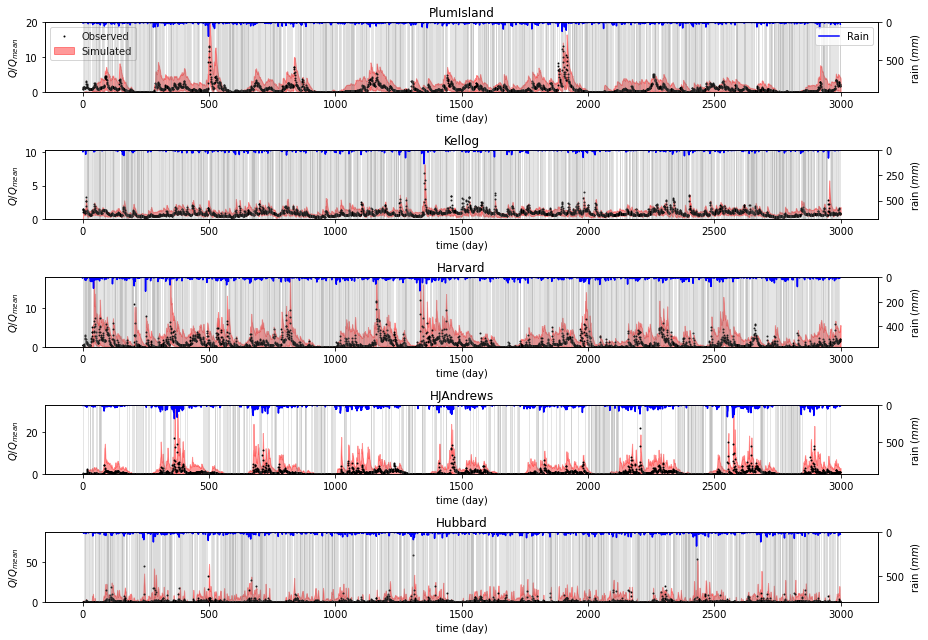

In [15]:
# Plot without parametric uncertainty
fig, ax_left = plt.subplots(5, figsize=(13, 9))
name =["PlumIsland","Kellog","Harvard","HJAndrews","Hubbard"]
for i in range(5):
    
    ax_right = ax_left[i].twinx()

    ax_left[i].plot(discharge_obs[i,:], '.',color='black',markersize =2)
    #ax_left.plot(discharge_sim[i,:],color='black',linewidth=1)
    ax_left[i].fill_between(np.linspace(0., 3000, 3000),np.percentile(discharge_sim_en[i,:,:], 5, axis=1), np.percentile(discharge_sim_en[i,:,:], 95, axis=1), color='red', alpha=0.4)

    ax_right.invert_yaxis()
    ax_right.plot(rain_obs[i,:], color='blue')
    ax_right.fill_between(range(len(rain_obs[i,:])), min(rain_obs[i,:]), 1000, where=(rain_obs[i,:]==0) & (rain_obs[i,:] > -0.1), alpha=0.2, color ="gray")
    ax_left[i].set_ylim([0, 1.5*max(discharge_obs[i,:])])
    ax_right.set_ylim([5*max(rain_obs[i,:]),0])
    ax_left[i].set_xlabel('time (day)')
    ax_left[i].set_ylabel(r'$Q/Q_{mean}$')
    ax_right.set_ylabel(r'rain $(mm)$')#,rotation=-90)
    
    if i == 0:
            ax_right.legend(['Rain'], loc = 'upper right')
            ax_left[i].legend(['Observed','Simulated'], loc = 'upper left' )
    
    ax_left[i].set_title(name[i])
    plt.tight_layout()

plt.savefig('images/hydrograph.jpg')

In [16]:
# Reliability
n=np.zeros(5)

for i in range(5):
    ci5 = np.percentile(discharge_sim_en[i,:,:], 5, axis=1)
    ci95 = np.percentile(discharge_sim_en[i,:,:], 95, axis=1)
    for j in range(3000):
        if   ci5[j] < discharge_obs[i,j] and ci95[j] > discharge_obs[i,j]: 
            n[i] = n[i]+1

print(n/3000*100)            

# Reliability
ns=np.zeros(5)

for i in range(5):
    mn = np.mean(discharge_sim_en[i,:,:],axis=1)
    ns[i]=1-np.mean((discharge_obs[i,:]-mn)**2)/np.mean((discharge_obs[i,:]-np.mean(discharge_obs[i,:]))**2)
    
print(ns)

[86.43333333 91.96666667 86.3        82.73333333 71.73333333]
[ 0.74201475  0.56482366  0.56198994  0.57025633 -0.01598528]


In [19]:
# for 2 parameters
#Plot with parametric uncertainty
discharge_sim_en = np.zeros([5,3000, 100])

for i in range(5):
    for j in range(100):
        para = paroptim[i,:]
        para[1]=np.array(eval('{}{}'.format('samplespar', i)))[j*2,0]
        para[8]=np.array(eval('{}{}'.format('samplespar', i)))[j*2,1]
        para[8] = 0.05
        discharge_sim_en[i,:,j] = sde(para, rain_obs[i,:], Temp_obs[i,:],runs =1).flatten()

In [20]:
#Plot with parametric uncertainty
#discharge_sim_en = np.zeros([5,3000, 100])

#for i in range(5):
#    for j in range(100):
#        discharge_sim_en[i,:,j] = sde(np.array(eval('{}{}'.format('samplespar', i)))[j*2,:], rain_obs[i,:], Temp_obs[i,:],runs =1).flatten()

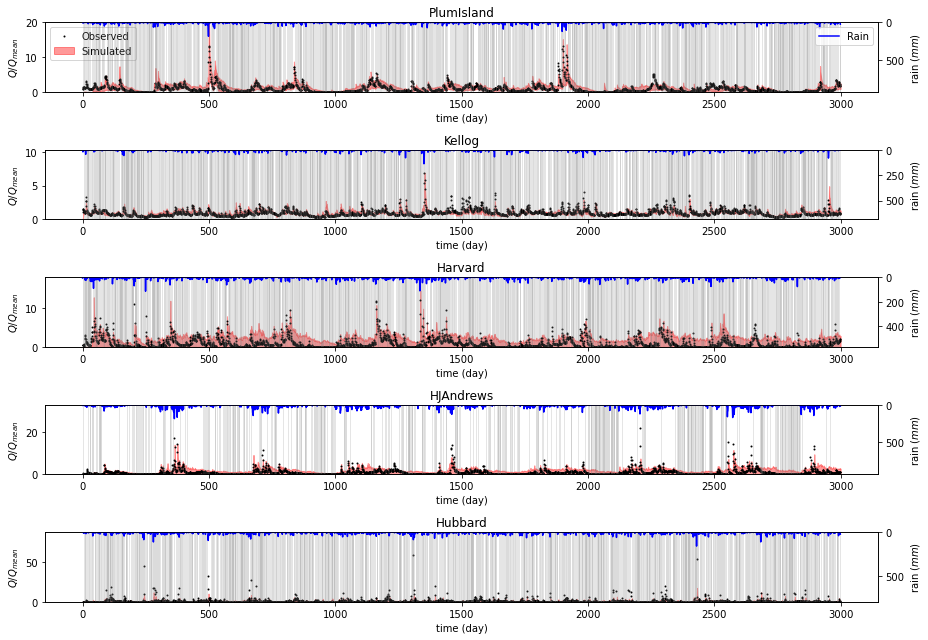

In [21]:
# Plot with parametric uncertainty
fig, ax_left = plt.subplots(5, figsize=(13, 9))
name =["PlumIsland","Kellog","Harvard","HJAndrews","Hubbard"]
for i in range(5):
    
    ax_right = ax_left[i].twinx()

    ax_left[i].plot(discharge_obs[i,:], '.',color='black',markersize =2)
    #ax_left.plot(discharge_sim[i,:],color='black',linewidth=1)
    ax_left[i].fill_between(np.linspace(0., 3000, 3000),np.percentile(discharge_sim_en[i,:,:], 5, axis=1), np.percentile(discharge_sim_en[i,:,:], 95, axis=1), color='red', alpha=0.4)

    ax_right.invert_yaxis()
    ax_right.plot(rain_obs[i,:], color='blue')
    ax_right.fill_between(range(len(rain_obs[i,:])), min(rain_obs[i,:]), 1000, where=(rain_obs[i,:]==0) & (rain_obs[i,:] > -0.1), alpha=0.2, color ="gray")
    ax_left[i].set_ylim([0, 1.5*max(discharge_obs[i,:])])
    ax_right.set_ylim([5*max(rain_obs[i,:]),0])
    ax_left[i].set_xlabel('time (day)')
    ax_left[i].set_ylabel(r'$Q/Q_{mean}$')
    ax_right.set_ylabel(r'rain $(mm)$')#,rotation=-90)
    
    if i == 0:
            ax_right.legend(['Rain'], loc = 'upper right')
            ax_left[i].legend(['Observed','Simulated'], loc = 'upper left' )
    
    ax_left[i].set_title(name[i])
    plt.tight_layout()

plt.savefig('images/hydrograph.jpg')

In [22]:
# Reliability
n=np.zeros(5)

for i in range(5):
    ci5 = np.percentile(discharge_sim_en[i,:,:], 5, axis=1)
    ci95 = np.percentile(discharge_sim_en[i,:,:], 95, axis=1)
    for j in range(3000):
        if  ci5[j] < discharge_obs[i,j] and ci95[j] > discharge_obs[i,j]:
            n[i] = n[i]+1

print(n/3000*100)            

# Reliability
ns=np.zeros(5)

for i in range(5):
    mn = np.mean(discharge_sim_en[i,:,:],axis=1)
    ns[i]=1-np.mean((discharge_obs[i,:]-mn)**2)/np.mean((discharge_obs[i,:]-np.mean(discharge_obs[i,:]))**2)
    
print(ns)

[80.26666667 42.9        81.66666667 94.96666667  6.2       ]
[0.69717773 0.55454297 0.27153093 0.3460475  0.13586918]


# TE

In [92]:
from PyIF import te_compute as te
rand = np.random.RandomState(seed=23)

TE=np.zeros([5,3,3])

for i in range(5):
    for j in range(3):
        X = rain_obs[i,:]
        Y_obs = discharge_obs[i,:]
        Y_sde = sde(np.append(paroptim[i,0:8],j*paroptim*[i,9]), (rain_obs[i,:]), Temp_obs[i,:],runs =1).flatten()
        Y_ode = sde(np.append(paroptim[i,0:8],0), (rain_obs[i,:]), Temp_obs[i,:],runs =1).flatten()

        TE[i,0,j] = te.te_compute(X, Y_obs, k=1, embedding=j+1, safetyCheck=False, GPU=False) # embedding is the lag
        TE[i,1,j] = te.te_compute(X,Y_sde, k=1, embedding=j+1, safetyCheck=False, GPU=False)
        TE[i,2,j] = te.te_compute(X, Y_ode , k=1, embedding=j+1, safetyCheck=False, GPU=False)
# we find that the first lag has the highest entropy

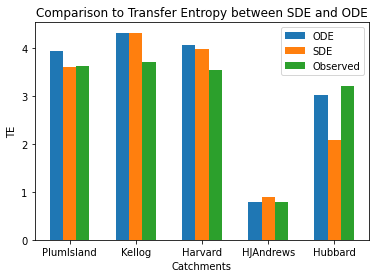

In [93]:
X = ["PlumIsland","Kellog","Harvard","HJAndrews","Hubbard"]
obs = TE[:,0,j]
sde = TE[:,1,j]
ode = TE[:,2,j]

X_axis = np.arange(len(X))
  

plt.bar(X_axis - 0.2, ode, width = 0.2, label = 'ODE')
plt.bar(X_axis + 0., sde, width = 0.2, label = 'SDE')
plt.bar(X_axis + 0.2, obs, width = 0.2, label = 'Observed')
  
plt.xticks(X_axis, X)
plt.xlabel("Catchments")
plt.ylabel("TE")
plt.title("Comparison to Transfer Entropy between SDE and ODE")
plt.legend()
plt.show()

# Slider for recession plot

In [28]:
import plotly.graph_objects as go
import plotly.express as px
rand = np.random.RandomState(seed=25)
def myfun_es(es):
    par0=paroptim[0,:]
    par0[1]=1.3
    par0[8]=es
    return np.array(sde(par0, rain_obs[0,:], Temp_obs[0,:],runs =1).flatten()) 


# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for es in np.arange(0, 0.1, 0.01):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(es),
            x=np.arange(0, 3000, 1),
            y=myfun_es(es)))

# Make 10th trace visible
fig.data[0].visible = True

# Create and add slider
ess = []
for i in range(len(fig.data)):
    es = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "es value: " + str(0.02*i)}],  # layout attribute
    )
    es["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    ess.append(es)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "es value: "},
    pad={"t": 50},
    steps=ess
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

#### PLot two

def myfun_b(b):
    par0=paroptim[0,:]
    par0[1]=b
    par0[8]=0
    return np.array(sde(par0, rain_obs[0,:], Temp_obs[0,:],runs =1).flatten()) 


# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for b in np.arange(1, 1.8, 0.1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(b),
            x=np.arange(0, 3000, 1),
            y=myfun_b(b)))

# Make 10th trace visible
fig.data[0].visible = True

# Create and add slider
bs = []
for i in range(len(fig.data)):
    b = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "b value: " + str(0.5 + 0.1*i)}],  # layout attribute
    )
    b["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    bs.append(b)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "b value: "},
    pad={"t": 50},
    steps=bs
)]

fig.update_layout(
    sliders=sliders
)

fig.show()


# Make multiple recession plots

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.04, 'Differences in streamflow-recession relationships for Observations and SDE [assuming $dQ/dt \\propto Q^b$]')

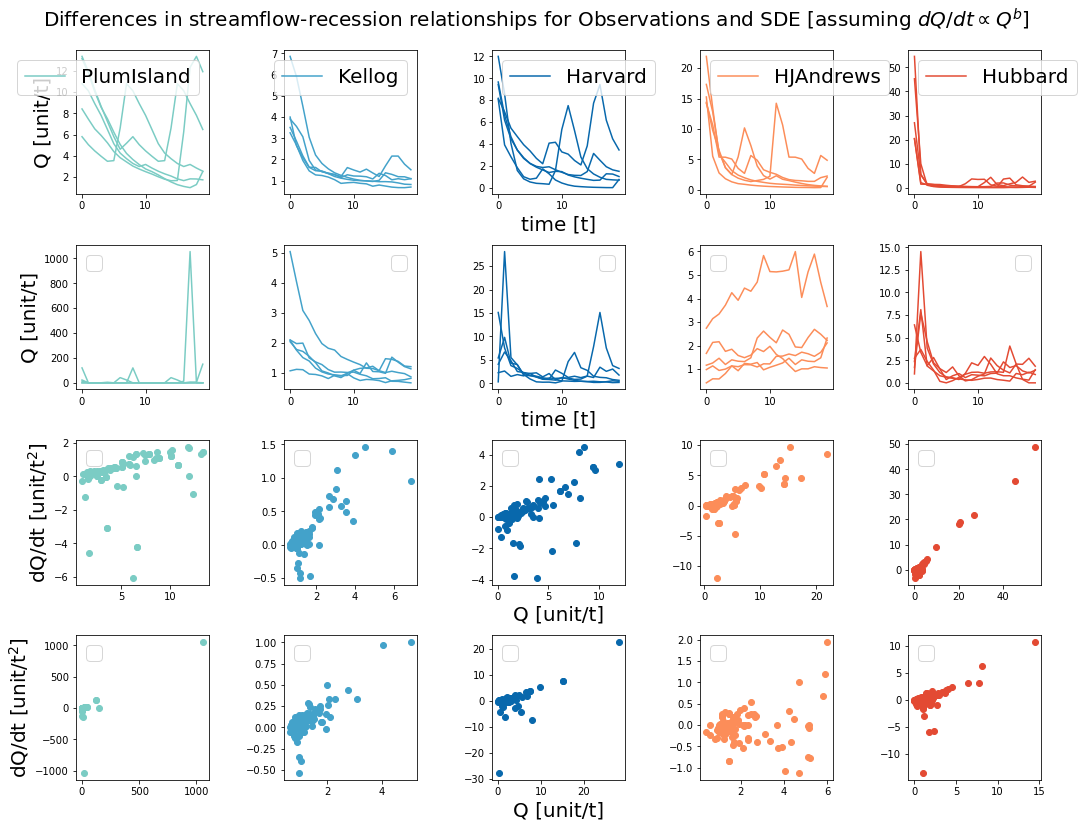

In [230]:
fig, ax = plt.subplots(4,5, figsize=(15, 11))
colours=['#7bccc4','#43a2ca','#0868ac','#fc8d59','#e34a33']
name=["PlumIsland","Kellog","Harvard","HJAndrews","Hubbard"]
random.seed(10)

for i in range(5):
    
    Q = np.array(discharge_obs[i,:])
    param = paroptim[i,:]
    param[8]=0.05
    Qsim = sde(param, rain_obs[i,:], Temp_obs[i,:],runs =1).flatten()
    
    indices = np.array(sg.argrelextrema(Q, np.greater)).ravel()
    index2=indices[np.where(np.diff(indices)>5)]              # get indices for the local maxima in the 1D array
    Qmax = np.array(Q[index2]).ravel()                         # get the corresponding maxima
    indices0 = int(np.where(Q==Qmax[(-Qmax).argsort()[0]])[0]) # get the indices 5 biggest maxima
    indices1 = int(np.where(Q==Qmax[(-Qmax).argsort()[1]])[0])
    indices2 = int(np.where(Q==Qmax[(-Qmax).argsort()[2]])[0])
    indices3 = int(np.where(Q==Qmax[(-Qmax).argsort()[3]])[0])
    indices4 = int(np.where(Q==Qmax[(-Qmax).argsort()[4]])[0])

    q0 = Q[indices0:(indices0+20)]
    q1 = Q[indices1:(indices1+20)]
    q2 = Q[indices2:(indices2+20)]
    q3 = Q[indices3:(indices3+20)]
    q4 = Q[indices4:(indices4+20)]
    diff0 =np.append(-np.diff(q0),0)
    diff1 =np.append(-np.diff(q1),0)
    diff2 =np.append(-np.diff(q2),0)
    diff3 =np.append(-np.diff(q3),0)
    diff4 =np.append(-np.diff(q4),0)
    
    
    qsim0 = Qsim[indices0:(indices0+20)]
    qsim1 = Qsim[indices1:(indices1+20)]
    qsim2 = Qsim[indices2:(indices2+20)]
    qsim3 = Qsim[indices3:(indices3+20)]
    qsim4 = Qsim[indices4:(indices4+20)]
    diffsim0 =np.append(-np.diff(qsim0),0)
    diffsim1 =np.append(-np.diff(qsim1),0)
    diffsim2 =np.append(-np.diff(qsim2),0)
    diffsim3 =np.append(-np.diff(qsim3),0)
    diffsim4 =np.append(-np.diff(qsim4),0)
    
    ax[0,i].plot(q0, color = colours[i],label = f"{name[i]}")
    ax[0,i].plot(q1, color = colours[i])
    ax[0,i].plot(q2, color = colours[i])
    ax[0,i].plot(q3, color = colours[i])
    ax[0,i].plot(q4, color = colours[i])
    #ax[0,i].set_yticklabels([])
    #ax[i].set_xticklabels([])
    ax[0,i].legend(loc ='best',fontsize = 20)
    ax[0,0].set_ylabel('Q [unit/t]', fontsize = 20)
    ax[0,2].set_xlabel('time [t]', fontsize = 20)
    

    # for SDE 
    ax[1,i].plot(qsim0, color = colours[i])
    ax[1,i].plot(qsim1, color = colours[i])
    ax[1,i].plot(qsim2, color = colours[i])
    ax[1,i].plot(qsim3, color = colours[i])
    ax[1,i].plot(qsim4, color = colours[i])
    #ax[1,i].set_yticklabels([])
    #ax[i].set_xticklabels([])
    ax[1,i].legend(loc ='best',fontsize = 20)
    ax[1,0].set_ylabel('Q [unit/t]', fontsize = 20)
    ax[1,2].set_xlabel('time [t]', fontsize = 20)
    
    
    ax[2,i].scatter(x=q0,y=diff0, color = colours[i])
    ax[2,i].scatter(x=q1,y=diff1, color = colours[i])
    ax[2,i].scatter(x=q2,y=diff2, color = colours[i])
    ax[2,i].scatter(x=q3,y=diff3, color = colours[i])
    ax[2,i].scatter(x=q4,y=diff4, color = colours[i])
    #ax[2,i].set_yticklabels([])
    #ax[2,i].set_xticklabels([])
    ax[2,i].legend(loc ='upper left',fontsize = 20)
    ax[2,0].set_ylabel('dQ/dt [unit/t$^2$]', fontsize = 20)
    ax[2,2].set_xlabel('Q [unit/t]', fontsize = 20)
       
    # for SDE 
    ax[3,i].scatter(x=qsim0,y=diffsim0, color = colours[i])
    ax[3,i].scatter(x=qsim1,y=diffsim1, color = colours[i])
    ax[3,i].scatter(x=qsim2,y=diffsim2, color = colours[i])
    ax[3,i].scatter(x=qsim3,y=diffsim3, color = colours[i])
    ax[3,i].scatter(x=qsim4,y=diffsim4, color = colours[i])
    #ax[3,i].set_yticklabels([])
    #ax[3,i].set_xticklabels([])
    ax[3,i].legend(loc ='upper left',fontsize = 20)
    ax[3,0].set_ylabel('dQ/dt [unit/t$^2$]', fontsize = 20)
    ax[3,2].set_xlabel('Q [unit/t]', fontsize = 20)
    
    plt.tight_layout()

fig.suptitle('Differences in streamflow-recession relationships for Observations and SDE [assuming $dQ/dt \propto Q^b$]',y=1.04,fontsize = 20)
#plt.savefig('images/recession.jpeg',bbox_inches='tight')

# Slider for tranfer entropy

# Preliminary anlysis of the storage-discharge relationship

In [ ]:
par = paroptim
par[2,(7,8)]=[-1,0.4]
par[:,8]=[0,0,0,0,0]
par[:,8]=[0.1,0.1,0.1,0.1,0.1]

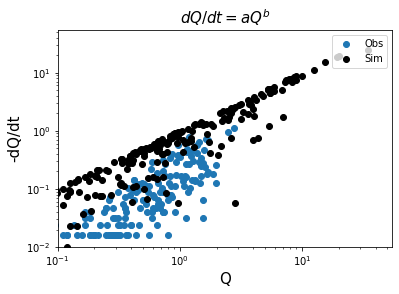

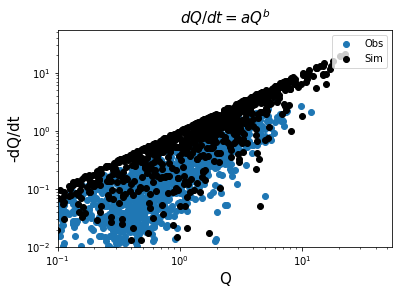

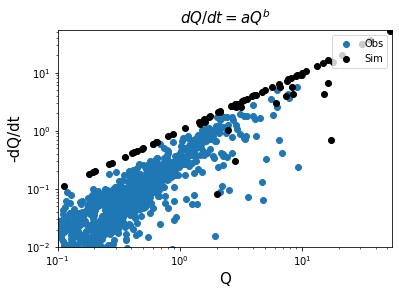

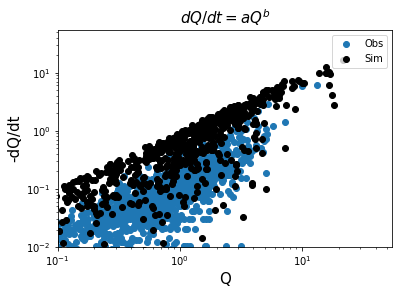

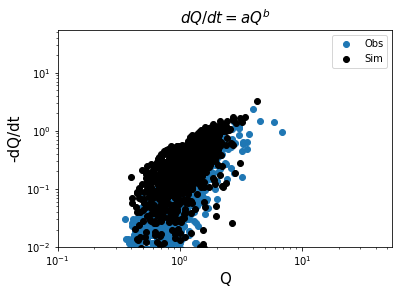

In [41]:
for i in range(5):
    par[i,:]
    #par_test = {'A':1,'b':1.,'k':2.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'es':0.0} 
    #par_test = np.array(list(par_test.values()))

    
    plt.figure(i)

    discharge_special = discharge_obs[i,:][np.where(rain_obs[i,:]<=0.0*np.max(rain_obs[i,:]))]
    dQ = np.diff(discharge_special)

    plt.scatter(y=-dQ[dQ<0],x=discharge_special[np.where(dQ<0)])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.1, 55)
    plt.ylim(0.01, 55)
    plt.ylabel('-dQ/dt', fontsize = 15)
    plt.xlabel('Q', fontsize = 15)
    plt.title('$dQ/dt=aQ^b$', fontsize = 15)
    
    
    discharge = sde(par[i,:], rain_obs[i,:], Temp_obs[i,:],runs =4).flatten()
    discharge_special = discharge[np.where(rain_obs[i,:]<=0.0*np.max(rain_obs[i,:]))]
    dQ = np.diff(discharge_special)
        
    plt.scatter(y=-dQ[dQ<0],x=discharge_special[np.where(dQ<0)],color ="black")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.1, 55)
    plt.ylim(0.01, 55)
    plt.ylabel('-dQ/dt', fontsize = 15)
    plt.xlabel('Q', fontsize = 15)
    plt.title('$dQ/dt=aQ^b$', fontsize = 15)
    plt.legend(['Obs','Sim'], loc = 'upper right')

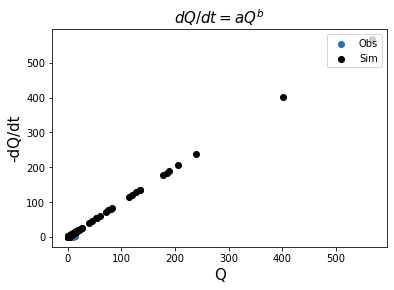

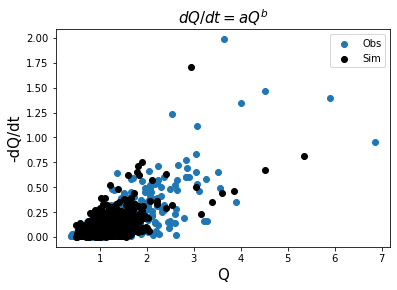

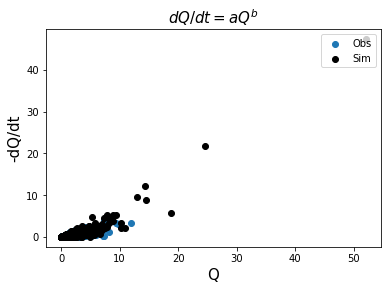

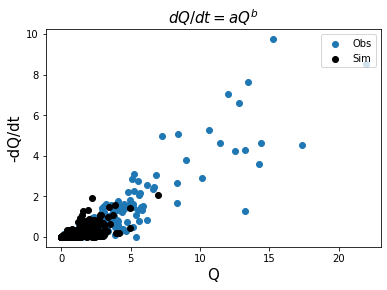

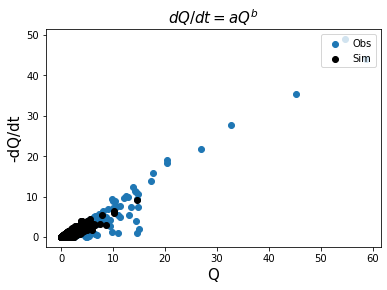

In [231]:
for i in range(5):
    par[i,:]
    #par_test = {'A':1,'b':1.,'k':2.,'Qref':0.3,'ddf':0.0,'Emax':0.0,'Emin':0.,'es':0.0} 
    #par_test = np.array(list(par_test.values()))

    
    plt.figure(i)
    
    Q = discharge_obs[i,:]
    indices = [i for i in range(len(Q)-4) if (Q[i]>Q[i+1]>Q[i+2]>Q[i+3])] 
    #discharge_special = discharge_obs[i,:][np.where(rain_obs[i,:]<=0.0*np.max(rain_obs[i,:]))]
    discharge_special = Q[indices]    
    dQ = np.diff(discharge_special)

    ind = np.where(np.diff(np.where(dQ<0))==1)    
    plt.scatter(y=-dQ[dQ<0],x=discharge_special[np.where(dQ<0)])
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.xlim(0.1, 55)
    #plt.ylim(0.01, 55)
    plt.ylabel('-dQ/dt', fontsize = 15)
    plt.xlabel('Q', fontsize = 15)
    plt.title('$dQ/dt=aQ^b$', fontsize = 15)
    
    
    discharge = sde(par[i,:], rain_obs[i,:], Temp_obs[i,:],runs =1).flatten()
    Q = discharge
    #indices = [i for i in range(len(Q)-4) if (Q[i]<Q[i+1]<Q[i+2]<Q[i+3])] 
    #discharge_special = discharge[np.where(rain_obs[i,:]<=0.0*np.max(rain_obs[i,:]))]
    discharge_special = Q[indices] 
    dQ = np.diff(discharge_special)
        
    plt.scatter(y=-dQ[dQ<0],x=discharge_special[np.where(dQ<0)],color ="black")
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.xlim(0.1, 55)
    #plt.ylim(0.01, 55)
    plt.ylabel('-dQ/dt', fontsize = 15)
    plt.xlabel('Q', fontsize = 15)
    plt.title('$dQ/dt=aQ^b$', fontsize = 15)
    plt.legend(['Obs','Sim'], loc = 'upper right')

In [ ]:
plt.acorr(discharge, maxlags = 30)

# Create the distribution of time to peak

In [ ]:
from scipy.signal import argrelextrema

# for local maxima
dis_max =np.asarray(argrelextrema(discharge, np.greater))[0,:]
rain_max =np.asarray(argrelextrema(rain, np.greater))[0,:]

type(dis_max)

# for local minima
#argrelextrema(x, np.less)

In [ ]:
rain_max.shape

In [ ]:
sns.kdeplot(rain_max, bw = 0.5)

In [ ]:
from PyIF import te_compute as te
import numpy as np
rand = np.random.RandomState(seed=23)

X_1000 = rain
Y_1000 = discharge

TE = te.te_compute(X_1000, Y_1000, k=1, embedding=2, safetyCheck=False, GPU=False)

print(TE)

# Performance

In [ ]:

ci5 = np.percentile(sim, 5, axis=1)
ci95 = np.percentile(sim, 95, axis=1)

n=0
for i in range(1500):
    if  ci5[i] < discharge[i] and ci95[i] > discharge[i]:
        n = n+1

In [ ]:
#Reliability

ci5 = np.percentile(sim, 5, axis=1)
ci95 = np.percentile(sim, 95, axis=1)

n=0
for i in range(1500):
    if  ci5[1500+i] < discharge[1500+i] and ci95[1500+i] > discharge[1500+i]:
        n = n+1


In [ ]:
n/1500*100  

#HJ Andrew
# 63.3 calibration
# 67.8 validation

#Kellog
# 72.66 calibration
# 70.66 validation

#Konza 
#18.33 calibration
# 18.94 validation

# Generate dynamic plot

In [129]:
from PyIF import te_compute as te
rand = np.random.RandomState(seed=23)

TE=np.zeros([5,3,3])

for i in range(5):
    for j in range(3):
        X = rain_obs[i,:]
        Y_obs = discharge_obs[i,:]
        Y_sde = sde(np.append(paroptim[i,0:8],(j**2)*paroptim[i,8]), (rain_obs[i,:]), Temp_obs[i,:],runs =1).flatten()
        Y_ode = sde(np.append(paroptim[i,0:8],0), (rain_obs[i,:]), Temp_obs[i,:],runs =1).flatten()

        TE[i,0,j] = te.te_compute(X, Y_obs, k=1, embedding=1, safetyCheck=False, GPU=False) # embedding is the lag
        TE[i,1,j] = te.te_compute(X,Y_sde, k=1, embedding=1, safetyCheck=False, GPU=False)
        TE[i,2,j] = te.te_compute(X, Y_ode , k=1, embedding=1, safetyCheck=False, GPU=False)
# we find that the first lag has the highest entropy

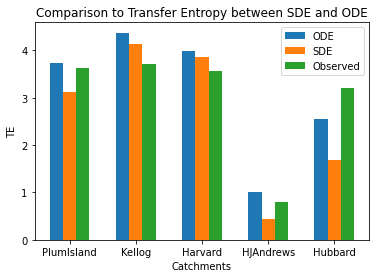

In [130]:
X = ["PlumIsland","Kellog","Harvard","HJAndrews","Hubbard"]
j=2
obs = TE[:,0,j]
sde = TE[:,1,j]
ode = TE[:,2,j]

X_axis = np.arange(len(X))
  

plt.bar(X_axis - 0.2, ode, width = 0.2, label = 'ODE')
plt.bar(X_axis + 0., sde, width = 0.2, label = 'SDE')
plt.bar(X_axis + 0.2, obs, width = 0.2, label = 'Observed')
  
plt.xticks(X_axis, X)
plt.xlabel("Catchments")
plt.ylabel("TE")
plt.title("Comparison to Transfer Entropy between SDE and ODE")
plt.legend()
plt.show()

In [111]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import IPython.display as IPdisplay, matplotlib.font_manager as fm
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image

In [112]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')

In [113]:
save_folder = 'images/dynamicTE'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [138]:
def plot_TE(n):
    X = ["PlumIsland","Kellog","Harvard","HJAndrews","Hubbard"]
    obs = TE[:,0,n]
    sde = TE[:,1,n]
    ode = TE[:,2,n]

    X_axis = np.arange(len(X))

    plt.figure(figsize = (8,5))
    plt.bar(X_axis - 0.2, ode, width = 0.2, label = 'ODE')
    plt.bar(X_axis + 0., sde, width = 0.2, label = 'SDE')
    plt.bar(X_axis + 0.2, obs, width = 0.2, label = 'Observed')

    plt.xticks(X_axis, X)
    plt.xlabel("Catchments")
    plt.ylabel("TE")
    plt.title('{}{}'.format("Comparison of Transfer Entropy metric for SDE and ODE - Es:", n))
    plt.legend()
    plt.savefig('{}/{:03d}.png'.format(save_folder, n), dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close()

In [139]:
for n in range(3):
    plot_TE(n)

In [140]:
# load all the static images into a list
save_folder = 'images/dynamicTE'
images = [Image.open(image) for image in glob.glob('{}/*.png'.format(save_folder))]
gif_filepath = 'images/animatedTE.gif'

In [141]:
# save as an animated gif
gif = images[0]
gif.info['duration'] = 800 #ms per frame
gif.info['loop'] = 0 #how many times to loop (0=infinite)
gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:],quality=50)

In [142]:
# verify that the number of frames in the gif equals the number of image files and durations
Image.open(gif_filepath).n_frames == len(images) 

True